<div style="width:90%; text-align:center; border-width: 0px; display:block; margin-left:auto; margin-right:auto; background-color:off white; position: relative;">
  <div class="alert alert-block alert-success" style="text-align:center; color:white; background-color:#1e2124 !important;">
    <img src="https://raw.githubusercontent.com/monnomero/IA-para-fisica/main/Imagens/logo_unb.png" style="width: 200px; opacity:0.85;">
    <h1>Universidade de Brasília</h1>
    <h2>Instituto de Física</h2>
    <hr style="width:44%;border:1px solid white;">
    <h3>Mini Curso de Inteligência Artificial para a Física</h3> 
    <h4>Henrique de Oliveira Noronha</h4>
    <hr style="width:44%;border:1px solid white;">
  </div>
  <img src="https://raw.githubusercontent.com/monnomero/IA-para-fisica/main/Imagens/logo_if.png" style="position: absolute; bottom: 20px; left: 40px; width: 100px;">
</div>


# **➲ Generalização dos osciladores harmônicos amortecidos**
---
Para esse exemplo, vamos usar as LSTMs para treinar um modelo que consiga aprender a evolução temporal dos osciladores harmônicos com a EDO com os mesmos parâmetros, para um intervalo de diferentes condições iniciais.

Temos que a EDO que governa o sitema então é:

\begin{equation*}
    \frac{d²x}{dt²} = -2\zeta\omega_0\frac{dx}{dt} - \omega_0²x
\end{equation*}

Vamos resolver a EDO usando odeint para 16 condições iniciais diferentes com a posição inicial entre -5 e 5, e velocidade inicial entre -1 e 1. Então, vamos treinar o modelo com os dados das posições dessas soluções e verificar se o modelo aprendeu, testando em condições geradas aleatoriamente nesses intervalos.

In [ ]:
import numpy as np
from scipy.integrate import odeint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

In [7]:
def criar_sequencias(X, N_intervalos):
    sequencias_entrada = []
    sequencias_saida = []
    L = X.shape[0]
    for i in range(L-N_intervalos):
        entrada = X[i:i+N_intervalos,:]
        saida = X[i+N_intervalos:i+N_intervalos+1,:]
        sequencias_entrada.append(entrada)
        sequencias_saida.append(saida)
    return np.array(sequencias_entrada), np.squeeze(np.array(sequencias_saida),axis=1) # Squeeze para corrigir o shape das saídas para ser (batches,features), sem ele fica (batches,1,features)


In [8]:
# Parametros
zeta = 0.1                # Fator de amortecimento
k = 2.0                   # Constante da mola
m = 1.0                   # Massa
omega_n = np.sqrt(k/m)    # Frequencia natural
t = np.arange(0, 10.1, 0.1)  # Tempo dt = 0.1
N_intervalos = 10

def oscilador_amortecido(y, t):
    x1, x2 = y
    dydt = [x2, -2 * zeta * omega_n * x2 - omega_n**2 * x1]
    return dydt

# Criar dados de treinamento
solucoes = []
x0s = [-5.0,-2.5,2.5,5.0]
v0s = [-1.0,-0.5,0.5,1.0]
for x0 in x0s:
    for v0 in v0s:
        solucao = odeint(oscilador_amortecido, [x0,v0], t)[:,0].reshape(-1,1)
        solucoes.append(solucao)

entradas_treinamento = []
saidas_treinamento = []
for solucao in solucoes:
    entradas,saidas = criar_sequencias(solucao,N_intervalos)
    entradas_treinamento.append(entradas)
    saidas_treinamento.append(saidas)
entradas_treinamento = np.concatenate(entradas_treinamento)
saidas_treinamento = np.concatenate(saidas_treinamento)
#Criar dados de validação
solucoes = []
x0s = [-3.5,1.0]
v0s = [-1.0,-0.5,0.5,1.0]
for x0 in x0s:
    for v0 in v0s:
        solucao = odeint(oscilador_amortecido, [x0,v0], t)[:,0].reshape(-1,1)
        solucoes.append(solucao)

entradas_validacao = []
saidas_validacao = []
for solucao in solucoes:
    entradas,saidas = criar_sequencias(solucao,N_intervalos)
    entradas_validacao.append(entradas)
    saidas_validacao.append(saidas)

entradas_validacao = np.concatenate(entradas_validacao)
saidas_validacao = np.concatenate(saidas_validacao)


In [9]:
modelo = Sequential([Input((N_intervalos,1)),
                     LSTM(20,return_sequences=True),
                     LSTM(20,return_sequences=False),
                     Dense(1,activation="linear")
                     ])
modelo.compile(optimizer=Adam(learning_rate=1e-4),loss="mse",metrics=["mae"]) # Compilar o modelo com ADAM, função de perda MSE e vamos observar a MAE (erro absoluto médio)
modelo.summary()

I0000 00:00:1762291610.935028   12478 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1107 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070 SUPER, pci bus id: 0000:01:00.0, compute capability: 8.9


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 10, 20)         │         1,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 20)             │         3,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,061 (19.77 KB)

 Trainable params: 5,061 (19.77 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
modelo_ja_treinado = True # Variavel para decidir se vai carregar um modelo já treinado ou treinar o modelo
if modelo_ja_treinado == True:
    modelo.load_weights('/modelos/oscilador_harmonico1.weights.h5') # Mude para o diretorio correto caso necessário
else:
    early_stopping = EarlyStopping(monitor="val_loss",patience=100)
    historico = modelo.fit(entradas_treinamento,saidas_treinamento,validation_data=(entradas_validacao,saidas_validacao),epochs=5000, batch_size=128,verbose=2)

In [13]:
#Fazer dados de teste
solucoes = []
np.random.seed(42) #Fixar a semente para obter os mesmos testes

for i in range(20):
    x0 = np.random.uniform(-5.0,5.0)
    v0 = np.random.uniform(-1.0,1.0)
    solucao = odeint(oscilador_amortecido, [x0,v0], t)[:,0].reshape(-1,1)
    solucoes.append(solucao)

entradas_teste= []
saidas_teste = []
for solucao in solucoes:
    entradas,saidas = criar_sequencias(solucao,N_intervalos)
    entradas_teste.append(entradas)
    saidas_teste.append(saidas)

entradas_teste = np.concatenate(entradas_teste)
saidas_teste = np.concatenate(saidas_teste)

metricas_teste = modelo.evaluate(entradas_teste,saidas_teste,verbose=0)
print(f"MSE do teste: {metricas_teste[0]}, MAE do teste: {metricas_teste[1]}")

MSE do teste: 9.515606507193297e-07, MAE do teste: 0.0006670788279734552


Posição inicial: -3.77962, Velocidade inicial: -0.00965


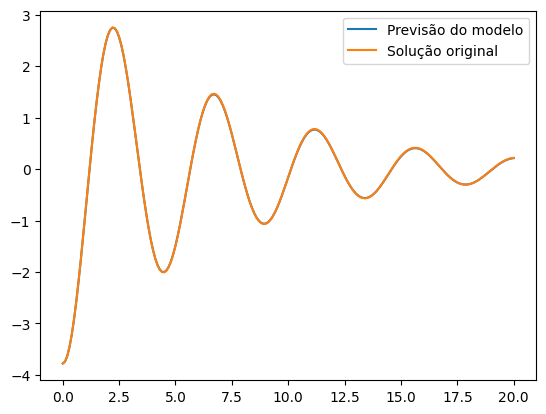

In [14]:
#Vamos verificar com uma solucao aleatória até 20s
x0 = np.random.uniform(-5.0,5.0)
v0 = np.random.uniform(-1.0,1.0)
print(f"Posição inicial: {x0:.5f}, Velocidade inicial: {v0:.5f}")
t2 = np.arange(0,20.1,0.1)
solucao = odeint(oscilador_amortecido, [x0,v0], t2)[:,0].reshape(-1,1)


previsoes = solucao[0:10].tolist() # Transforma as primeiras posicoes em uma lista de posicoes
#Alimentar a rede neural iterativamente a partir da posicao inicial por 191 iterações de dt=0.1s, ou seja, 19.1s (A entrada cobre os primeiros 0.9s)
for i in range(191):
    previsao_i = modelo((np.array([previsoes[k][:] for k in range(i,N_intervalos+i)]).reshape(1,N_intervalos,1)),training=False) # Adicionar a previsão nova para os 9 intervalos anteriores para gerar a nova entrada para o modelo prever
    previsoes.append(previsao_i.numpy().tolist()[0])

previsoes = np.array(previsoes)

plt.plot(t2,previsoes,label="Previsão do modelo")
plt.plot(t2,solucao,label="Solução original")
plt.legend()
plt.show()


Como podemos perceber, o modelo conseguiu aprender muito bem o comportamento do oscilador harmônico amortecido no intervalo dos dados, até para tempos de previsão maiores do que 10 segundos que foi o tempo que o modelo foi treinado. Vamos verificar se ele conseguiu aprender para condições iniciais longe das condições de treinamento. Vamos testar para $x_0$ = 7.5, $v_0$ = 1.5:

Posição inicial: 7.50000, Velocidade inicial: 1.50000


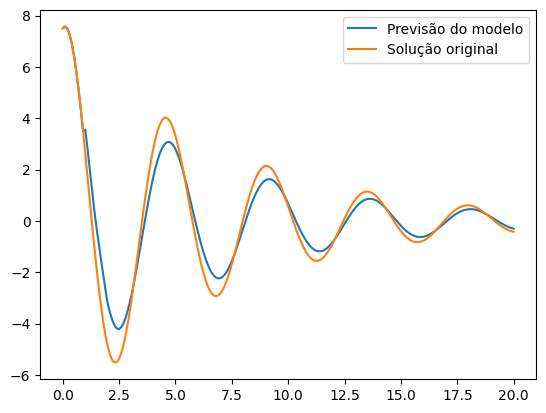

In [15]:
x0 = 7.5
v0 = 1.5
print(f"Posição inicial: {x0:.5f}, Velocidade inicial: {v0:.5f}")
t2 = np.arange(0,20.1,0.1)
solucao = odeint(oscilador_amortecido, [x0,v0], t2)[:,0].reshape(-1,1)


previsoes = solucao[0:10].tolist() # Transforma as primeiras posicoes em uma lista de posicoes
#Alimentar a rede neural iterativamente a partir da posicao inicial por 191 iterações de dt=0.1s, ou seja, 19.1s (A entrada cobre os primeiros 0.9s)
for i in range(191):
    previsao_i = modelo((np.array([previsoes[k][:] for k in range(i,N_intervalos+i)]).reshape(1,N_intervalos,1)),training=False) # Adicionar a previsão nova para os 9 intervalos anteriores para gerar a nova entrada para o modelo prever
    previsoes.append(previsao_i.numpy().tolist()[0])

previsoes = np.array(previsoes)

plt.plot(t2,previsoes,label="Previsão do modelo")
plt.plot(t2,solucao,label="Solução original")
plt.legend()
plt.show()

Infelizmente, o modelo não conseguiu aprender o comportamento total do oscilador harmônico amortecido para todas as condições iniciais. Longe disso, quando diferimos apenas 2.5 do intervalo da posição inicial de treinamento e 0.5 do intervalo da velocidade inicial de treinamento, já conseguimos um resultado ruim. Nesse caso, isso pode ser remediado por uma escolha de normalização dos dados que consiste em dividir todas as posições pela posição inicial. Já que, como o oscilador é amortecido, a solução é limitada. Claro que o limite da posição não necessariamente é a posição inicial, porém é um bom "chute".

Vamos testar essa abordagem para esse caso, mas note que isso exemplifica um problema que as LSTMs normalmente têm em problemas físicos do tipo, que, sem uma normalização adequada, ficam limitadas ao intervalo de treinamento.

In [16]:
# Criar dados de treinamento
solucoes = []
x0s = [-5.0,-2.5,2.5,5.0]
v0s = [-1.0,-0.5,0.5,1.0]
for x0 in x0s:
    for v0 in v0s:
        solucao = odeint(oscilador_amortecido, [x0,v0], t)[:,0].reshape(-1,1)
        solucao = solucao/solucao[0] # Dividir todas as posições pela posição inicial
        solucoes.append(solucao)

entradas_treinamento_normalizado = []
saidas_treinamento_normalizado = []
for solucao in solucoes:
    entradas,saidas = criar_sequencias(solucao,N_intervalos)
    entradas_treinamento_normalizado.append(entradas)
    saidas_treinamento_normalizado.append(saidas)
entradas_treinamento_normalizado= np.concatenate(entradas_treinamento_normalizado)
saidas_treinamento_normalizado = np.concatenate(saidas_treinamento_normalizado)
#Criar dados de validação
solucoes = []
x0s = [-3.5,1.0]
v0s = [-1.0,-0.5,0.5,1.0]
for x0 in x0s:
    for v0 in v0s:
        solucao = odeint(oscilador_amortecido, [x0,v0], t)[:,0].reshape(-1,1)
        solucao = solucao/solucao[0] # Dividir todas as posições pela posição inicial
        solucoes.append(solucao)

entradas_validacao_normalizado = []
saidas_validacao_normalizado = []
for solucao in solucoes:
    entradas,saidas = criar_sequencias(solucao,N_intervalos)
    entradas_validacao_normalizado.append(entradas)
    saidas_validacao_normalizado.append(saidas)

entradas_validacao_normalizado= np.concatenate(entradas_validacao_normalizado)
saidas_validacao_normalizado = np.concatenate(saidas_validacao_normalizado)

In [17]:
modelo_normalizado = Sequential([Input((N_intervalos,1)),
                     LSTM(20,return_sequences=True),
                     LSTM(20,return_sequences=False),
                     Dense(1,activation="linear")
                     ])
modelo_normalizado.compile(optimizer=Adam(learning_rate=1e-4),loss="mse",metrics=["mae"]) # Compilar o modelo com ADAM, função de perda MSE e vamos observar a MAE (erro absoluto médio)
modelo_normalizado.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 10, 20)         │         1,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 20)             │         3,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,061 (19.77 KB)

 Trainable params: 5,061 (19.77 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
modelo_ja_treinado = True # Variavel para decidir se vai carregar um modelo já treinado ou treinar o modelo
if modelo_ja_treinado == True:
    modelo_normalizado.load_weights('/modelos/oscilador_harmonico2.weights.h5') # Mude para o diretorio correto caso necessário
else:
    early_stopping = EarlyStopping(monitor="val_loss",patience=100,restore_best_weights=True)
    historico = modelo_normalizado.fit(entradas_treinamento_normalizado,saidas_treinamento_normalizado,
                                       validation_data=(entradas_validacao_normalizado,saidas_validacao_normalizado),epochs=5000, batch_size=128,verbose=2)

In [19]:
#Fazer dados de teste
solucoes = []
np.random.seed(42) #Fixar a semente para obter os mesmos testes

for i in range(20):
    x0 = np.random.uniform(-5.0,5.0)
    v0 = np.random.uniform(-1.0,1.0)
    solucao = odeint(oscilador_amortecido, [x0,v0], t)[:,0].reshape(-1,1)
    solucao = solucao/solucao[0]
    solucoes.append(solucao)

entradas_teste= []
saidas_teste = []
for solucao in solucoes:
    entradas,saidas = criar_sequencias(solucao,N_intervalos)
    entradas_teste.append(entradas)
    saidas_teste.append(saidas)

entradas_teste = np.concatenate(entradas_teste)
saidas_teste = np.concatenate(saidas_teste)

metricas_teste = modelo_normalizado.evaluate(entradas_teste,saidas_teste,verbose=0)
print(f"MSE do teste: {metricas_teste[0]}, MAE do teste: {metricas_teste[1]}")

MSE do teste: 7.493399323266203e-08, MAE do teste: 0.00012391259951982647


Como o objetivo é ver se ele generalizou melhor, vamos testar logo uma condição inicial bem mais longe do treinamento, $x_0$ = 17.5 e $v_0$ = -12.5

Posição inicial: 17.50000, Velocidade inicial: -12.50000
[17.5]


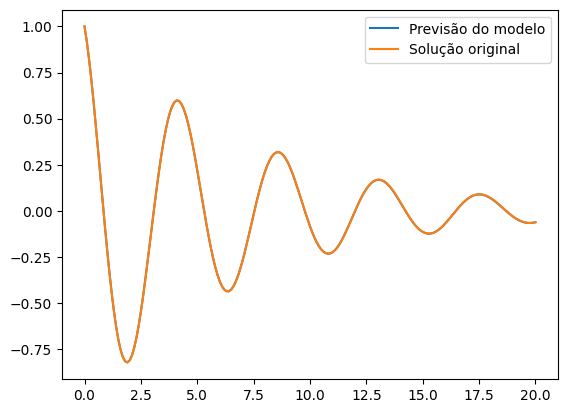

In [20]:
x0 = 17.5
v0 = -12.5
print(f"Posição inicial: {x0:.5f}, Velocidade inicial: {v0:.5f}")
t2 = np.arange(0,20.1,0.1)
solucao = odeint(oscilador_amortecido, [x0,v0], t2)[:,0].reshape(-1,1)
print(solucao[0])
solucao = solucao/solucao[0]


previsoes = solucao[0:10].tolist() # Transforma as primeiras posicoes em uma lista de posicoes
#Alimentar a rede neural iterativamente a partir da posicao inicial por 191 iterações de dt=0.1s, ou seja, 19.1s (A entrada cobre os primeiros 0.9s)
for i in range(191):
    previsao_i = modelo_normalizado((np.array([previsoes[k][:] for k in range(i,N_intervalos+i)]).reshape(1,N_intervalos,1)),training=False) # Adicionar a previsão nova para os 9 intervalos anteriores para gerar a nova entrada para o modelo prever
    previsoes.append(previsao_i.numpy().tolist()[0])

previsoes = np.array(previsoes)

plt.plot(t2,previsoes,label="Previsão do modelo")
plt.plot(t2,solucao,label="Solução original")
plt.legend()
plt.show()

**Sucesso! O modelo conseguiu generalizar muito bem para condições iniciais bem longe do intervalo de treinamento.**